In [1]:
# First, import required libraries
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing and Cleaning

In [2]:
# Load your JSON data
with open('EdilsonsProjects.AgriBot_SMS_Data.json', 'r') as f:
    data = json.load(f)

In [3]:
def extract_harvest_frequency(frequency_str):
    """Extracts numeric harvest frequency from string"""
    try:
        return int(frequency_str.split()[0])
    except:
        return None

def clean_product_name(product):
    """Cleans and standardizes product names"""
    product = product.strip().lower()
    
    # Split products that contain 'and' or commas
    products = []
    
    # First split by comma
    comma_split = product.split(',')
    for item in comma_split:
        # Then split by 'and'
        and_split = item.split(' and ')
        products.extend(and_split)
    
    # Clean each product
    cleaned_products = []
    for p in products:
        p = p.strip()
        if p:  # Only add non-empty products
            cleaned_products.append(p)
            
    return cleaned_products

def clean_main_df(df):
    """Applies additional cleaning to the main DataFrame"""
    # Sort by submission date
    df = df.sort_values('submission_date')
    
    # Convert region and constituency to title case
    df['region'] = df['region'].str.title()
    df['constituency'] = df['constituency'].str.title()
    
    # Create submission_month and submission_year columns for time-based analysis
    df['submission_month'] = df['submission_date'].dt.month
    df['submission_year'] = df['submission_date'].dt.year
    
    return df

def clean_products_df(df):
    """Applies additional cleaning to the products DataFrame"""
    # Remove duplicates
    df = df.drop_duplicates()
    
    # Standardize product names
    df['product'] = df['product'].str.title()
    
    return df

def preprocess_farmer_data(json_data):
    """
    Preprocesses and cleans farmer data from MongoDB export.
    """
    # Initialize lists to store normalized data
    main_records = []
    products_records = []
    raw_responses_records = []
    
    for record in json_data:
        # Extract main record information
        main_record = {
            'farmer_id': record['_id']['$oid'],
            'phone_number': record['phone_number'],
            'submission_date': pd.to_datetime(record['submission_date']['$date']),
            'name': record['personal_info']['name'],
            'date_of_birth': pd.to_datetime(record['personal_info']['date_of_birth'], format='%d %B %Y'),
            'age': pd.to_datetime('now').year - pd.to_datetime(record['personal_info']['date_of_birth'], format='%d %B %Y').year,
            'region': record['location']['region'],
            'constituency': record['location']['constituency'],
            'harvest_frequency': extract_harvest_frequency(record['farming_details']['harvest_frequency']),
            'has_government_assistance': record['farming_details']['government_assistance'].lower() == 'yes',
            'is_nab_certified': record['farming_details']['nab_certified'],
            'challenges': record['challenges']
        }
        main_records.append(main_record)
        
        # Extract products information
        for product in record['farming_details']['products']:
            # Get all products after splitting
            cleaned_products = clean_product_name(product)
            for clean_product in cleaned_products:
                products_record = {
                    'farmer_id': record['_id']['$oid'],
                    'product': clean_product
                }
                products_records.append(products_record)
        
        # Extract raw responses
        raw_response = {
            'farmer_id': record['_id']['$oid'],
            **record['raw_responses']
        }
        raw_responses_records.append(raw_response)
    
    # Create DataFrames
    main_df = pd.DataFrame(main_records)
    products_df = pd.DataFrame(products_records)
    raw_responses_df = pd.DataFrame(raw_responses_records)
    
    # Additional cleaning and formatting
    main_df = clean_main_df(main_df)
    products_df = clean_products_df(products_df)
    
    return main_df, products_df, raw_responses_df

In [4]:
# Process the data
main_df, products_df, raw_responses_df = preprocess_farmer_data(data)

In [86]:
# Examine the DataFrames
print("Main DataFrame:")
display(main_df)

Main DataFrame:


,farmer_id,phone_number,submission_date,name,date_of_birth,age,region,constituency,harvest_frequency,has_government_assistance,is_nab_certified,challenges,submission_month,submission_year
0,67208e32af224b1d581a8805,+264818779053,2024-10-29 07:26:42.818000+00:00,Edilson Zau,2003-10-24,21,Khomas,Windhoek,3,False,False,My main challenge is getting the funds for gro...,10,2024


In [80]:
print("\nProducts DataFrame:")
display(products_df)


Products DataFrame:


,farmer_id,product
0,67208e32af224b1d581a8805,Tomatoes
1,67208e32af224b1d581a8805,Carrots
2,67208e32af224b1d581a8805,Cabbage


In [82]:
print("\nRaw Responses DataFrame:")
display(raw_responses_df)


Raw Responses DataFrame:


,farmer_id,Are you certified by the Namibia Agronomic Board (NAB)? (Yes/No),Do you get any help from the Ministry of Agriculture Water and Land reform or any other institutions?,How often do you harvest?\n\n(Example: 3 or 4 Times a year),"What do you farm?\n\n(Please provide only your produce. Example: Tomatoes, potatoes, onions, and spinach)",What is your date of birth?\n\n(Please provide only your date of birth. Example: 12 November 1987),What is your name?\n\n(Please provide only your name. Example: Edilson Zau),"Where are you located?\n\n(Please provide your region and constituency. Example: Khomas, Windhoek)",What are your challenges? (Please be as detailed as possible)
0,67208e32af224b1d581a8805,No,No,3 Times a year,"Tomatoes, carrots and cabbage",24 October 2003,Edilson Zau,"Khomas, Windhoek",My main challenge is getting the funds for gro...


# Data Analytics

In [62]:
# Create visualizations
fig = (15, 10)

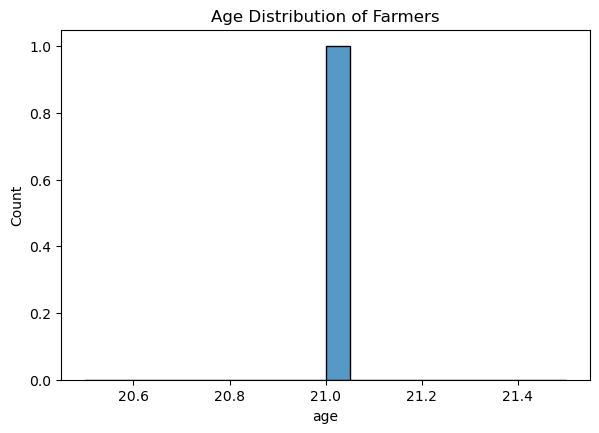

In [74]:
# 1. Age distribution
plt.figure(figsize=fig)
plt.subplot(2, 2, 1)
sns.histplot(data=main_df, x='age', bins=20)
plt.title('Age Distribution of Farmers')
plt.show()

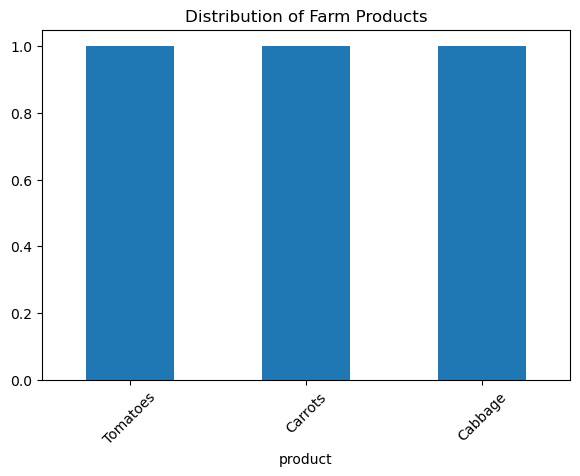

In [66]:
# 2. Product distribution
plt.figure(figsize=fig)
plt.subplot(2, 2, 2)
products_df['product'].value_counts().plot(kind='bar')
plt.title('Distribution of Farm Products')
plt.xticks(rotation=45)
plt.show()

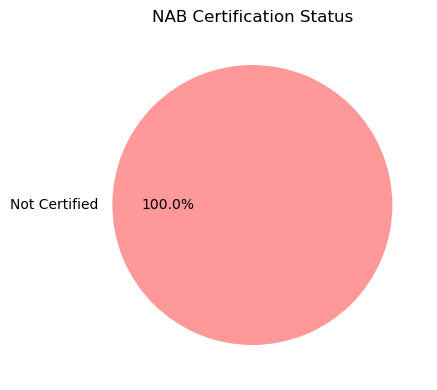

In [88]:
# 3. NAB Certification Status
plt.figure(figsize=fig)
plt.subplot(2, 2, 3)
certification_data = main_df['is_nab_certified'].value_counts()
labels = certification_data.index.map({True: 'NAB Certified', False: 'Not Certified'})
plt.pie(certification_data.values, 
        labels=labels,
        autopct='%1.1f%%',
        colors=['#ff9999','#66b3ff'])
plt.title('NAB Certification Status')
plt.show()

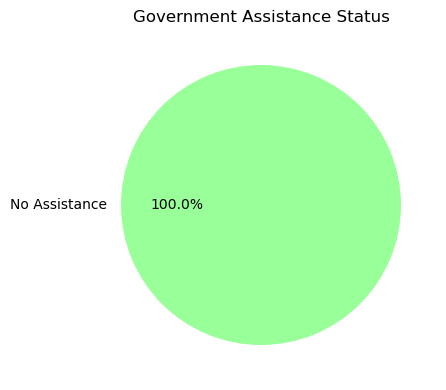

In [90]:
# 4. Government Assistance Status
plt.figure(figsize=fig)
plt.subplot(2, 2, 4)
assistance_data = main_df['has_government_assistance'].value_counts()
labels = assistance_data.index.map({True: 'Has Assistance', False: 'No Assistance'})
plt.pie(assistance_data.values,
        labels=labels,
        autopct='%1.1f%%',
        colors=['#99ff99','#ff99c2'])
plt.title('Government Assistance Status')
plt.show()

In [34]:
# Print summary statistics
print("\nProduct Distribution:")
print(products_df['product'].value_counts())


Product Distribution:
product
Tomatoes    1
Carrots     1
Cabbage     1
Name: count, dtype: int64
